In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

In [2]:
torch.manual_seed(111)

#####Create the sinusoidal

In [25]:
train_data = torch.zeros(1024, 2)
train_data[:, 0] = 2 * math.pi * torch.rand(1024)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(1024, 1)

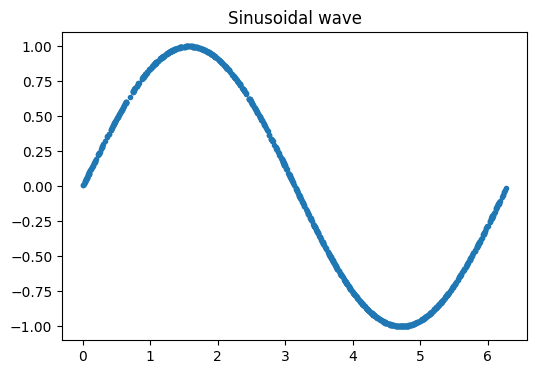

In [4]:
# Plot the data
plt.figure(figsize = (6, 4))
plt.plot(train_data[:, 0], train_data[:, 1], '.')
plt.title('sinusoidal wave'.capitalize())
plt.show()

#####Call the DataLoader with batch_size 32

In [5]:
BATCH_SIZE = 32
TRAIN_LOADER = DataLoader(dataset = list(zip(train_data, train_labels)), batch_size = BATCH_SIZE, shuffle = True)

train_data, train_label = next(iter(TRAIN_LOADER))

print("Batch size # {} ".format(TRAIN_LOADER.batch_size),'\n')
print("train data with batch_size  # {} ".capitalize().format(train_data.shape),'\n')
print("train label with batch_size # {} ".capitalize().format(train_label.shape))

Batch size # 32  

Train data with batch_size  # torch.Size([32, 2])  

Train label with batch_size # torch.Size([32, 1]) 


#####Create the Discriminator

In [6]:
"""
    Create a class named Discriminator that will take TWO parameters
      1. input_features : Define the features of the inpdenedent data
      2. out_features : Define how many target

    Create a sequential model that would take
      1. Dropout: Prevent the overfitting problem
      2. ReLU   : Prevent the vanishing gradient problem
      3. Sigmoid: Its a classification task, binary class
"""
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.MODEL = nn.Sequential(
            nn.Linear(in_features=2, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.MODEL(x)
        return x

In [7]:
# Call the model
discriminator = Discriminator()

print(discriminator)

Discriminator(
  (MODEL): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [8]:
# Find the trainable parameters
TRAINABLE_PARAMS = 0
for name, params in discriminator.named_parameters():
  if params.requires_grad == True:
    print("Layer - {} & trainable parameters # {} ".capitalize().format(name, params.numel()),'\n')
    TRAINABLE_PARAMS+= params.numel()

print("Total Trainable parameters # {} ".upper().format(TRAINABLE_PARAMS))

Layer - MODEL.0.weight & trainable parameters # 512  

Layer - MODEL.0.bias & trainable parameters # 256  

Layer - MODEL.3.weight & trainable parameters # 32768  

Layer - MODEL.3.bias & trainable parameters # 128  

Layer - MODEL.6.weight & trainable parameters # 8192  

Layer - MODEL.6.bias & trainable parameters # 64  

Layer - MODEL.9.weight & trainable parameters # 64  

Layer - MODEL.9.bias & trainable parameters # 1  

TOTAL TRAINABLE PARAMETERS # 41985 


In [9]:
# Summary the model of discriminator
summary(model = discriminator, input_size = train_data.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 32, 256]             768
              ReLU-2              [-1, 32, 256]               0
           Dropout-3              [-1, 32, 256]               0
            Linear-4              [-1, 32, 128]          32,896
              ReLU-5              [-1, 32, 128]               0
           Dropout-6              [-1, 32, 128]               0
            Linear-7               [-1, 32, 64]           8,256
              ReLU-8               [-1, 32, 64]               0
           Dropout-9               [-1, 32, 64]               0
           Linear-10                [-1, 32, 1]              65
          Sigmoid-11                [-1, 32, 1]               0
Total params: 41,985
Trainable params: 41,985
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

#####Create the Generator

In [10]:
"""
    Create a class named Generator that will take TWO parameters
      1. input_features : Define the features of the inpdenedent data
      2. out_features : Define how many target

    Create a sequential model that would take
      1. Dropout: Prevent the overfitting problem
      2. ReLU   : Prevent the vanishing gradient problem
"""
# Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.MODEL = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.ReLU(),

            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),

            nn.Linear(in_features=32, out_features=2)
        )

    def forward(self, x):
        x = self.MODEL(x)
        return x

In [11]:
# Call the model
generator = Generator()

print(generator)

Generator(
  (MODEL): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [12]:
# Find the trainable parameters
TRAINABLE_PARAMS = 0
for name, params in generator.named_parameters():
  if params.requires_grad == True:
    print("Layer - {} & trainable parameters # {} ".capitalize().format(name, params.numel()),'\n')
    TRAINABLE_PARAMS+= params.numel()

print("Total Trainable parameters # {} ".upper().format(TRAINABLE_PARAMS))

Layer - MODEL.0.weight & trainable parameters # 32  

Layer - MODEL.0.bias & trainable parameters # 16  

Layer - MODEL.2.weight & trainable parameters # 512  

Layer - MODEL.2.bias & trainable parameters # 32  

Layer - MODEL.4.weight & trainable parameters # 64  

Layer - MODEL.4.bias & trainable parameters # 2  

TOTAL TRAINABLE PARAMETERS # 658 


In [13]:
# Summary the model of discriminator
summary(model = generator, input_size = train_data.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 32, 16]              48
              ReLU-2               [-1, 32, 16]               0
            Linear-3               [-1, 32, 32]             544
              ReLU-4               [-1, 32, 32]               0
            Linear-5                [-1, 32, 2]              66
Total params: 658
Trainable params: 658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


#####Define the loss and optimizer

In [14]:
LEARNING_RATE = 0.001

loss_function = nn.BCELoss()
optimizer_discriminator = optim.Adam(params = discriminator.parameters(), lr = LEARNING_RATE)
optimizer_generator     = optim.Adam(params = generator.parameters(), lr = LEARNING_RATE)

print("Optimizer of Discriminator.\n\n{} ".format(optimizer_discriminator),'_'*50,'\n')
print("Optimizer of Generator.\n\n{} ".format(optimizer_generator))

Optimizer of Discriminator.

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)  __________________________________________________ 

Optimizer of Generator.

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
) 


#####Do the Training....

In [15]:
# EPOCHS = 1000
# DISCRIMINATOR_LOSS = []
# GENERATOR_LOSS     = []

# for epoch in range(EPOCHS):
#   total_discriminator_loss = []
#   total_generator_loss     = []

#   for (real_data, real_labels) in TRAIN_LOADER:

#     ############################
#     #       Discriminator      #
#     ############################
#     real_labels = torch.ones((BATCH_SIZE, 1))
#     fake_data   = torch.randn((BATCH_SIZE, 2))

#     generated_data   = generator(fake_data)
#     fake_labels = torch.zeros((BATCH_SIZE, 1))

#     merged_data = torch.cat((real_data, generated_data))
#     merged_label= torch.cat((real_labels, fake_labels))

#     discriminator.zero_grad()
#     discriminator_predict = discriminator(merged_data)
#     discriminator_loss    = loss_function(merged_label, discriminator_predict)

#     total_discriminator_loss.append(discriminator_loss.item())

#     discriminator_loss.backward()
#     optimizer_discriminator.step()
#     ############################
#     #         Generator        #
#     ############################

#     fake_data   = torch.randn(BATCH_SIZE, 2)
#     generator.zero_grad()
#     generated_data   = generator(fake_data)

#     generator_predict = generator(generated_data)
#     generator_output  = discriminator(generator_predict)
#     generator_loss    = loss_function(real_labels, generator_output)

#     total_generator_loss.append(generator_loss.item())

#     generator_loss.backward()
#     optimizer_generator.step()

#   DISCRIMINATOR_LOSS.append(np.array(total_discriminator_loss).mean())
#   GENERATOR_LOSS.append(np.array(total_generator_loss).mean())

#   print("Epoch - {}/{} ".format(epoch + 1, EPOCHS))
#   print("{}/{} [===================] Discriminator_loss: {} - Generator_loss: {} ".format(TRAIN_LOADER.batch_size,\
#                                                                                           TRAIN_LOADER.batch_size,\
#                                                                                           np.array(total_discriminator_loss).mean(),\
#                                                                                           np.array(total_generator_loss).mean()))

#####To prevent error

In [16]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader

# Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.MODEL = nn.Sequential(
            nn.Linear(in_features=2, out_features=16),
            nn.ReLU(),

            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),

            nn.Linear(in_features=32, out_features=2)
        )

    def forward(self, x):
        x = self.MODEL(x)
        return x

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.MODEL = nn.Sequential(
            nn.Linear(in_features=2, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.MODEL(x)
        return x

In [18]:
# Create instances of Generator and Discriminator
generator = Generator()
discriminator = Discriminator()

In [19]:
# Hyperparameters
EPOCHS = 1000
BATCH_SIZE = 32
LEARNING_RATE = 0.001

loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)

In [20]:
# Training loop
for epoch in range(EPOCHS):
    total_discriminator_loss = []
    total_generator_loss = []

    for real_data, real_labels in TRAIN_LOADER:
        ############################
        #       Discriminator      #
        ############################
        real_labels = torch.ones((BATCH_SIZE, 1))
        fake_data = torch.randn((BATCH_SIZE, 2))

        fake_data = generator(fake_data)
        fake_labels = torch.zeros((BATCH_SIZE, 1))

        merged_data = torch.cat((real_data, fake_data), dim=0)
        merged_labels = torch.cat((real_labels, fake_labels), dim=0)

        discriminator_predict = discriminator(merged_data)
        discriminator_loss = nn.BCELoss()(discriminator_predict, merged_labels)

        total_discriminator_loss.append(discriminator_loss.item())

        optimizer_discriminator.zero_grad()
        discriminator_loss.backward()
        optimizer_discriminator.step()

        ############################
        #         Generator        #
        ############################
        fake_data = torch.randn(BATCH_SIZE, 2)
        generated_data = generator(fake_data)

        generator_predict = discriminator(generated_data)
        generator_loss = nn.BCELoss()(generator_predict, real_labels)

        total_generator_loss.append(generator_loss.item())

        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()

    print("Epoch - {}/{} ".format(epoch + 1, EPOCHS))
    print("[=================] Discriminator_loss: {} - Generator_loss: {}".format(
        np.array(total_discriminator_loss).mean(),
        np.array(total_generator_loss).mean()
    ))


Epoch - 1/1000 
[=================] Discriminator_loss: 0.3413348328322172 - Generator_loss: 1.3303165175020695
Epoch - 2/1000 
[=================] Discriminator_loss: 0.3119063582853414 - Generator_loss: 2.6025951206684113
Epoch - 3/1000 
[=================] Discriminator_loss: 0.4281845949590206 - Generator_loss: 1.5460455641150475
Epoch - 4/1000 
[=================] Discriminator_loss: 0.4224998252466321 - Generator_loss: 1.4365350417792797
Epoch - 5/1000 
[=================] Discriminator_loss: 0.5349801164120436 - Generator_loss: 1.0561171751469374
Epoch - 6/1000 
[=================] Discriminator_loss: 0.49717534985393286 - Generator_loss: 1.105534614995122
Epoch - 7/1000 
[=================] Discriminator_loss: 0.5977320913225412 - Generator_loss: 1.1294496282935143
Epoch - 8/1000 
[=================] Discriminator_loss: 0.5154227269813418 - Generator_loss: 1.256645042449236
Epoch - 9/1000 
[=================] Discriminator_loss: 0.6581855276599526 - Generator_loss: 0.9344361647

In [21]:
latent_space_samples = torch.randn(500, 2)
genearted_samples = generator(latent_space_samples)

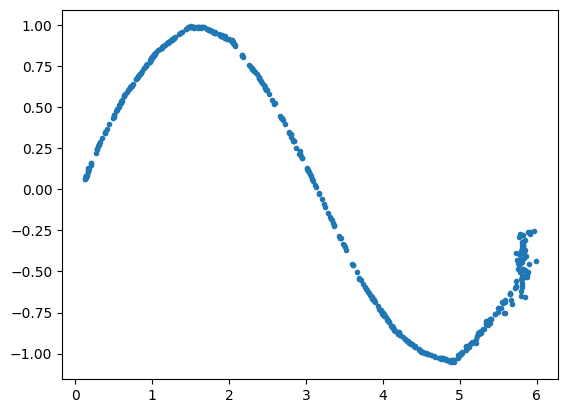

In [22]:
X = genearted_samples[:, 0].flatten().detach().numpy()
y = genearted_samples[:, 1].flatten().detach().numpy()
plt.plot(X, y, '.')

##### Display

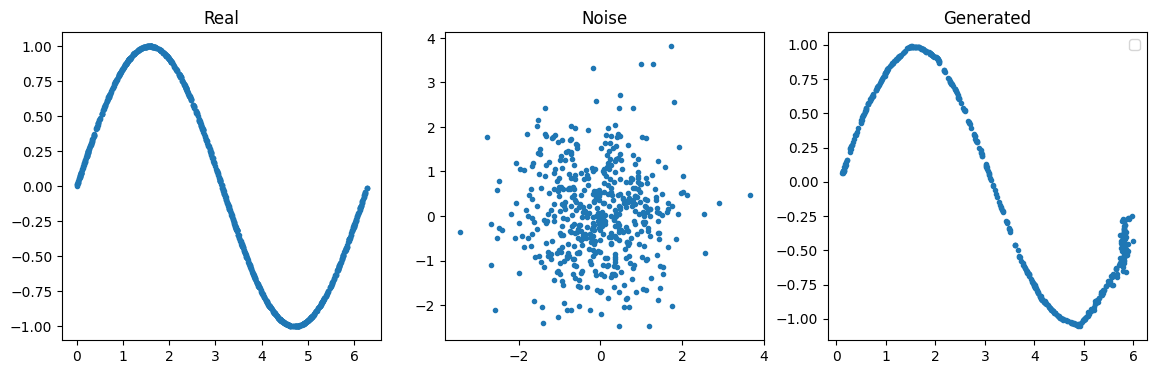

In [26]:
fig, axes = plt.subplots(1, 3, figsize = (14, 4))

axes[0].plot(train_data[:, 0], train_data[:, 1], '.')
axes[0].set_title('Real')

axes[1].plot(latent_space_samples[:, 0], latent_space_samples[:, 1], '.')
axes[1].set_title('Noise')

axes[2].plot(X, y, '.')
axes[2].set_title('Generated')

plt.legend()
plt.show()